In [6]:
import mne
import saflow
from saflow import BIDS_PATH
from saflow.utils import get_SAflow_bids
import pickle


In [7]:
subj = '08'
bloc = '3'

_, epopath = get_SAflow_bids(BIDS_PATH, subj, bloc, stage="-epo", cond=None)
_, rawpath = get_SAflow_bids(
    BIDS_PATH, subj, bloc, stage="preproc_raw", cond=None
)
_, ARpath = get_SAflow_bids(BIDS_PATH, subj, bloc, stage="ARlog", cond=None)
_, PSDpath = get_SAflow_bids(BIDS_PATH, subj, bloc, stage="PSD", cond=None)

# Load files
epochs = mne.read_epochs(epopath)
raw = mne.io.read_raw_fif(rawpath, preload=True)
with open(ARpath, "rb") as f:
    ARlog = pickle.load(f)
    
# Load epochs
FREQepochs, RAREepochs = split_trials(
    BIDS_PATH,
    LOGS_DIR,
    subj=subj,
    run=bloc,
    stage='PSD',
    by="odd",
    oddball="rares",
)

Reading /scratch/hyruuk/saflow_data/bids/sub-08/ses-recording/meg/sub-08_ses-recording_task-gradCPT_run-03_meg_-epo.fif ...
    Read 5 compensation matrices
    Found the data of interest:
        t =       0.00 ...     800.00 ms
        5 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
526 matching events found
No baseline correction applied
0 projection items activated
Opening raw data file /scratch/hyruuk/saflow_data/bids/sub-08/ses-recording/meg/sub-08_ses-recording_task-gradCPT_run-03_meg_preproc_raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 587999 =      0.000 ...   489.999 secs
Ready.
Current compensation grade : 3
Reading 0 ... 587999  =      0.000 ...   489.999 secs...


NameError: name 'split_trials' is not defined

Opening epochs-browser...


<IPython.core.display.Javascript object>


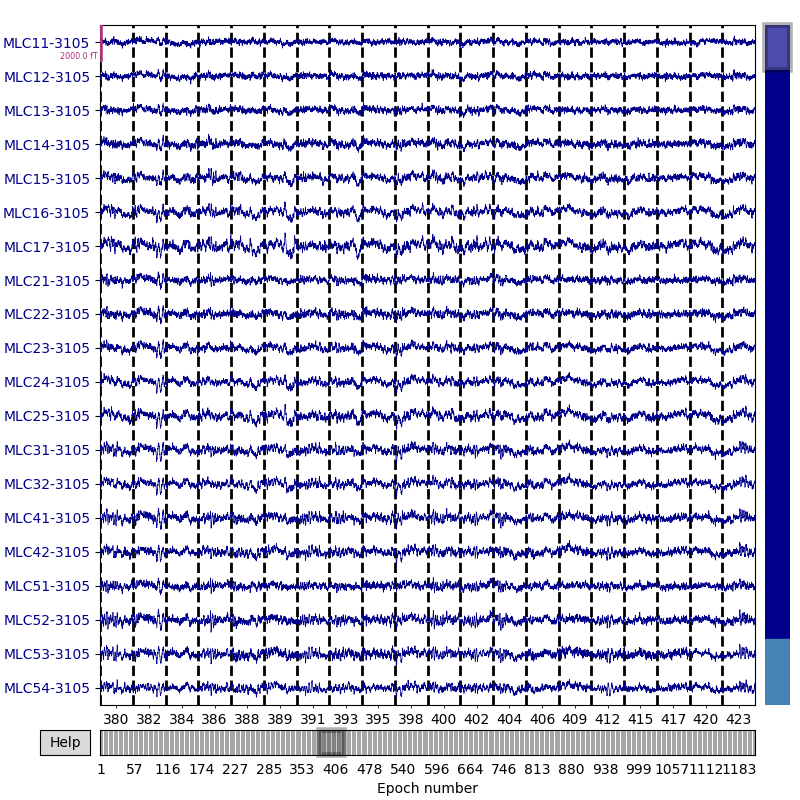

In [6]:
%matplotlib notebook
%matplotlib notebook
import matplotlib

epochs.plot();

Opening raw-browser...


<IPython.core.display.Javascript object>


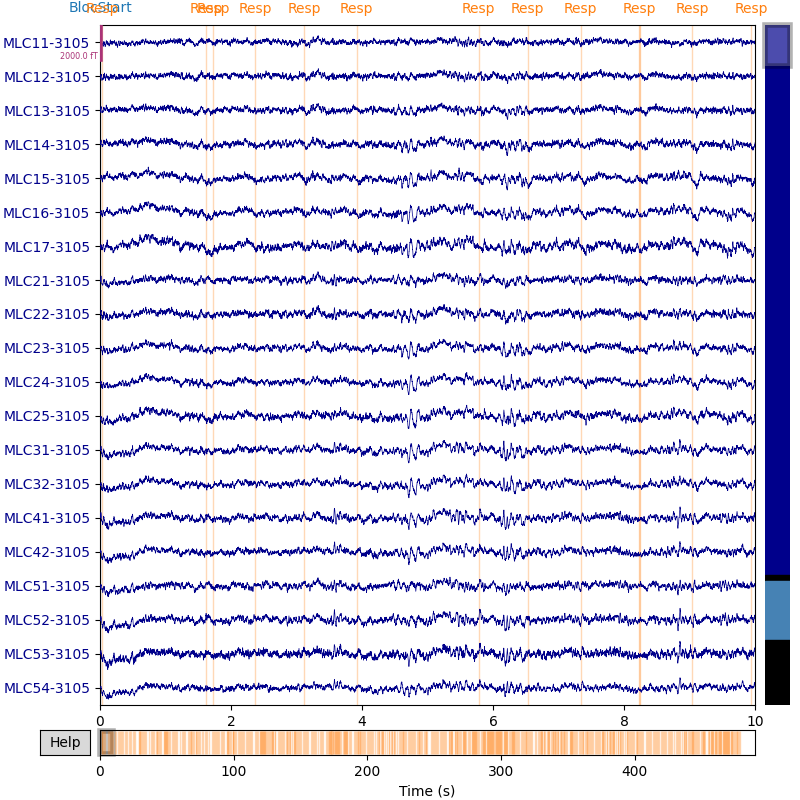

In [12]:
raw.plot();

In [13]:
epochs

Number of events,526
Events,Freq: 481Rare: 45
Time range,0.000 – 0.800 sec
Baseline,off


In [16]:
raw

<Raw | sub-08_ses-recording_task-gradCPT_run-03_meg_preproc_raw.fif, 334 x 588000 (490.0 s), ~1.46 GB, data loaded>

In [5]:
from saflow.neuro import *

psds = compute_PSD_hilbert(raw, ARlog=ARlog, freqlist=FREQS, tmin=0, tmax=0.8)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1981 samples (1.651 sec)

Not setting metadata
562 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 562 events and 961 original time points ...
0 bad epochs dropped
Dropped 36 epochs: 4, 14, 31, 32, 67, 68, 100, 153, 164, 167, 195, 207, 223, 230, 241, 248, 259, 301, 302, 303, 312, 316, 328, 335, 348, 349, 367, 38

(526, 270, 8)


In [15]:
toplot = np.mean(psds, axis=0)

In [21]:
from saflow.utils import array_topoplot, create_pval_mask, get_SAflow_bids
from saflow import *
pos = epochs.pick_types(
    meg=True, ref_meg=False
).info  # Find the channel positions

In [22]:
pos

<Info | 16 non-empty values
 bads: []
 ch_names: MLC11-3105, MLC12-3105, MLC13-3105, MLC14-3105, MLC15-3105, ...
 chs: 270 Magnetometers
 ctf_head_t: CTF/4D/KIT head -> head transform
 custom_ref_applied: False
 dev_ctf_t: MEG device -> CTF/4D/KIT head transform
 dev_head_t: MEG device -> head transform
 dig: 3 items (3 Cardinal)
 experimenter: Ping
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_results: 1 item (list)
 lowpass: 200.0 Hz
 meas_date: 2019-08-05 10:03:00 UTC
 meas_id: 4 items (dict)
 nchan: 270
 projs: []
 sfreq: 1200.0 Hz
 subject_info: 1 item (dict)
>

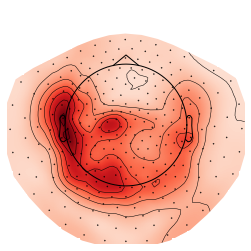

(<matplotlib.image.AxesImage at 0x14bc14409e50>,
 <matplotlib.contour.QuadContourSet at 0x14bc14409190>)

In [35]:
mne.viz.plot_topomap(toplot[:,3], pos=pos)

No projector specified for this dataset. Please consider the method self.add_proj.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


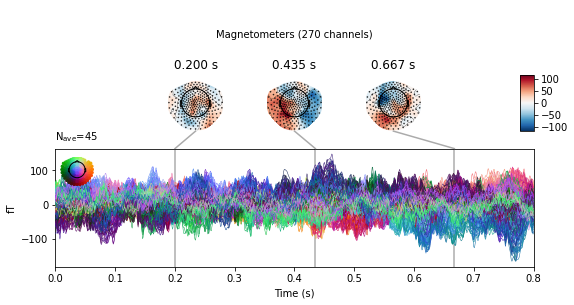

No projector specified for this dataset. Please consider the method self.add_proj.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


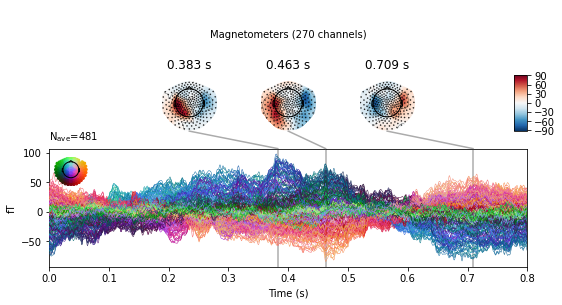

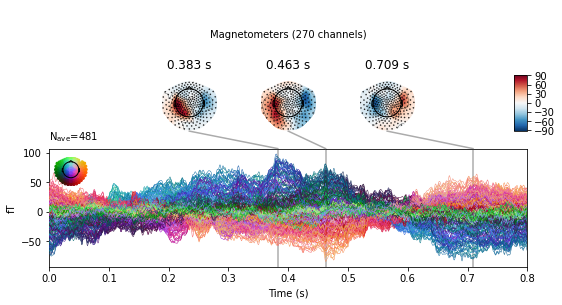

In [43]:
epochs['Rare'].average().plot_joint()
epochs['Freq'].average().plot_joint()

Number of events,526
Events,Freq: 481Rare: 45
Time range,0.000 – 0.800 sec
Baseline,off


In [17]:
low = 12
high = 20
data = raw.copy().filter(low, high)
hilbert = data.apply_hilbert(envelope=True)
hilbert_pow = hilbert.copy()
hilbert_pow._data = hilbert._data**2

# Segment them
picks = mne.pick_types(
    raw.info, meg=True, ref_meg=False, eeg=False, eog=False, stim=False
)
try:
    events = mne.find_events(
        raw, min_duration=1 / raw.info["sfreq"], verbose=False
    )
except ValueError:
    events = mne.find_events(
        raw, min_duration=2 / raw.info["sfreq"], verbose=False
    )
event_id = {"Freq": 21, "Rare": 31}
epochs = mne.Epochs(
    hilbert,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=0.8,
    baseline=None,
    reject=None,
    picks=picks,
    preload=True,
)
epochs.drop(ARlog.bad_epochs)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 12 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1321 samples (1.101 sec)

Not setting metadata
562 matching events found
Removing 5 compensators from info because not all compensation channels were picked.
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 562 events and 961 original time points ...
0 bad epochs dropped
Dropped 36 epochs: 4, 14, 31, 32, 67, 68, 100, 153, 164, 167, 195, 207, 223, 230, 241, 248, 259, 301, 302, 303, 312, 316, 328, 335, 348, 349, 3

Number of events,526
Events,Freq: 481Rare: 45
Time range,0.000 – 0.800 sec
Baseline,off


No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


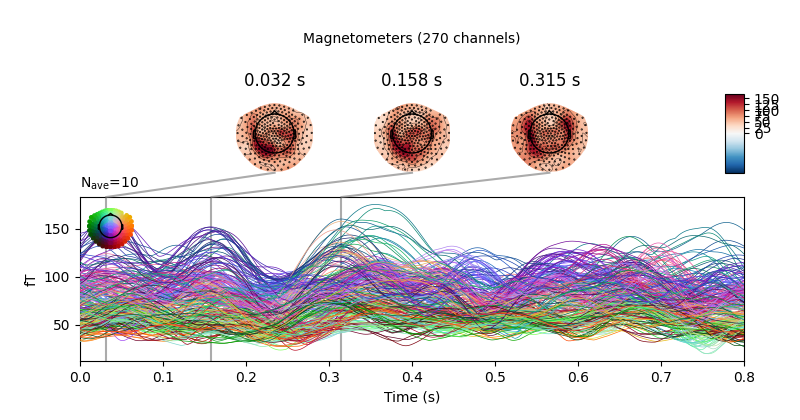

In [24]:
epochs['Rare'][:10].average().plot_joint();

Closing raw-browser...
Channels marked as bad:
none
Closing raw-browser...
Channels marked as bad:
none
Opening raw-browser...


<IPython.core.display.Javascript object>


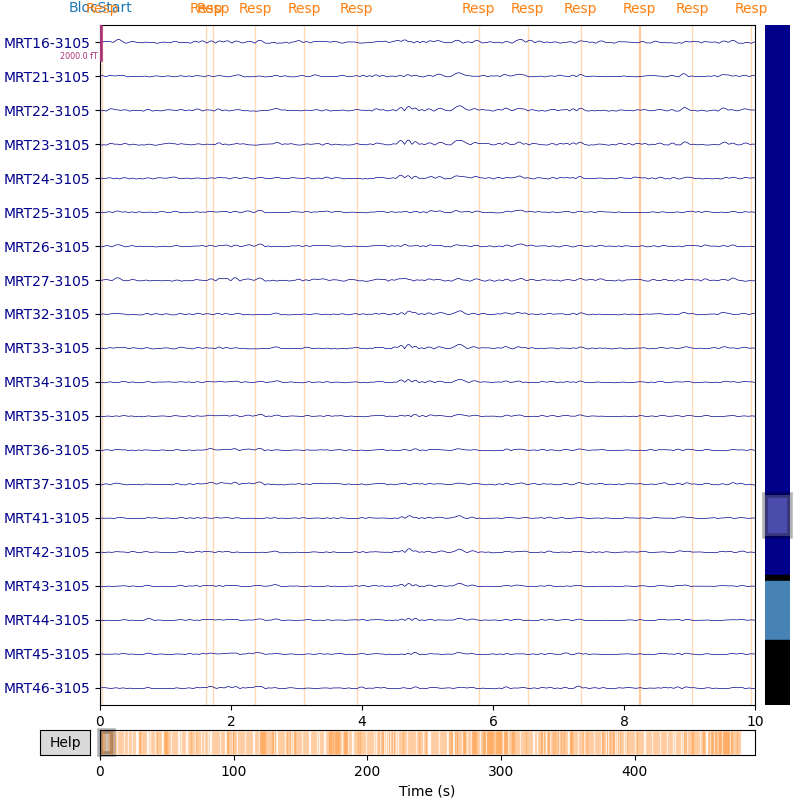

In [19]:
%matplotlib notebook
hilbert.plot();